In [4]:
# load libraries

import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt

from action_prediction import constants as const
from action_prediction.data import DataSet
from action_prediction import visualize as vis

%load_ext autoreload
%autoreload 2

In [5]:
# initialize dataset
data = DataSet(task='social_prediction')

# load behavior
df_behav = data.load_behav()

# load eyetracking
df_eye = data.load_eye(data_type='events')

# merge eyetracking with behav
df_merged = data.merge_behav_eye(dataframe_behav=df_behav, dataframe_eye=df_eye)


In [9]:
# initialize plotting style
vis.plotting_style()

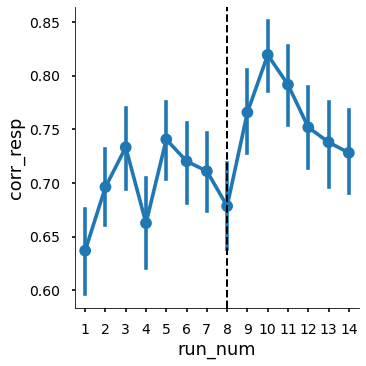

In [73]:
# visualize accuracy across runs
vis.plot_acc(dataframe=df_behav, x='run_num', hue=None)

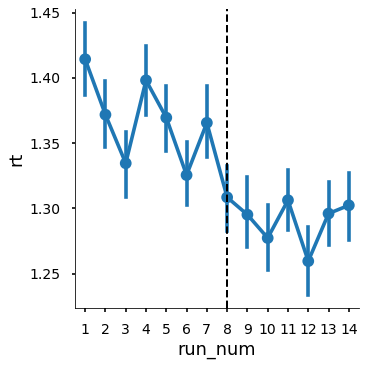

In [75]:
# visualize rt across runs
vis.plot_rt(dataframe=df_behav, x='run_num', hue=None)

In [ ]:
# plot diameter
# vis.plot_diameter(dataframe=df_merged)

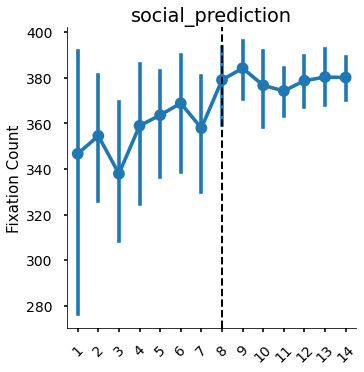

In [71]:
# plot fixation count
vis.plot_fixation_count(dataframe=df_merged, x='run_num')

In [76]:
# plot saccade counta
vis.plot_saccade_count(dataframe=df_merged, x='run_num')

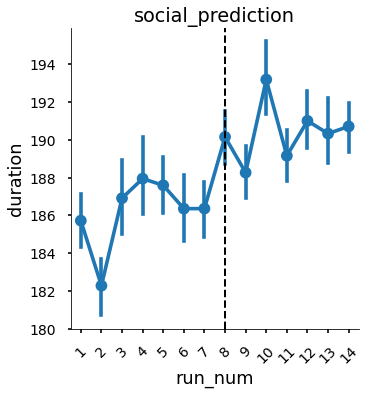

In [64]:
# plot fixation duration
vis.plot_fixation_duration(dataframe=df_merged, x='run_num')

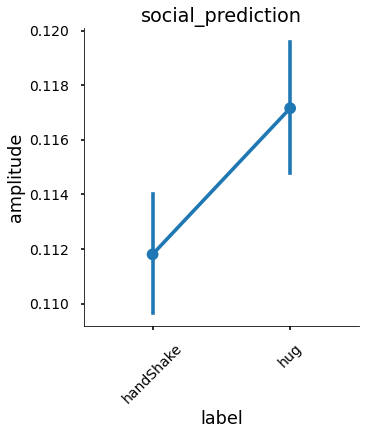

In [79]:
# plot amplitude
vis.plot_amplitude(dataframe=df_merged, x='label')

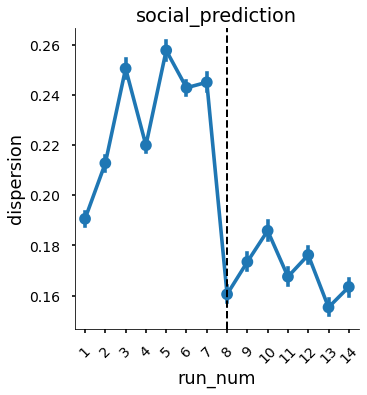

In [68]:
# plot dispersion
vis.plot_dispersion(dataframe=df_merged, x='run_num')

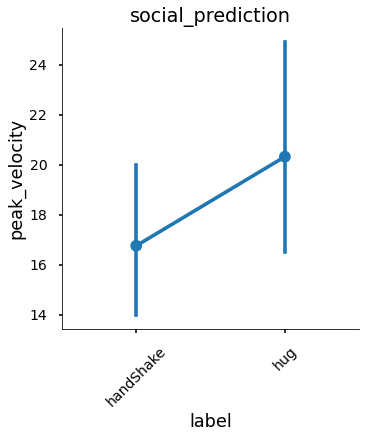

In [60]:
# plot peak velocity
vis.plot_peak_velocity(dataframe=df_merged, x='label')

In [ ]:
# heatmap

# one subj, one run
for run in range(14):
    tmp = df_eye[(df_eye['subj']=='sIU') & (df_eye['run_num']==run+1) & (df_eye['type']=="fixations")]
    vis.plot_gaze_positions(dataframe=tmp)
    plt.title(f'run{run+1}')

In [90]:
df = df_merged.groupby(['subj', 'sess', 'run_num','type', 'actors', 'label', 'condition_name']
                      ).agg({'rt': 'mean',
                            'corr_resp': 'mean', 
                            'dispersion': 'mean', 
                            'amplitude': 'mean', 
                            'peak_velocity': 'mean', 
                            'duration': 'mean'}).reset_index()

In [91]:
df_merged.columns

Index(['peak_velocity', 'amplitude', 'dispersion', 'start_gx', 'start_gy',
       'end_gx', 'end_gy', 'surface', 'end_time', 'type', 'duration',
       'mean_gx', 'mean_gy', 'block_iter', 'exp_event', 'task', 'event_type',
       'run_num', 'subtract', 'onset_sec', 'subj', 'sess', 'start_time',
       'actors', 'agents', 'angle', 'balance_exp', 'condition_name', 'context',
       'corr_key', 'corr_resp', 'dataset', 'display_trial_feedback',
       'extracted', 'feedback_type', 'hand', 'initiator',
       'initiator_start_frames', 'initiator_start_frames_corr',
       'initiator_start_frames_sec', 'interact_start_frames',
       'interact_start_frames_corr', 'interact_start_frames_sec', 'iti_dur',
       'label', 'media', 'real_start_time', 'replace_stimuli', 'resp_made',
       'rt', 'run_iter', 'session_type', 'stim', 'timestamp_sec', 'trial_dur',
       'trial_type', 'video_end', 'video_name', 'video_name_corrected',
       'video_start', 'block_iter_corr'],
      dtype='object')

In [80]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit()

,peak_velocity,amplitude,dispersion,start_gx,start_gy,end_gx,end_gy,surface,end_time,type,...,session_type,stim,timestamp_sec,trial_dur,trial_type,video_end,video_name,video_name_corrected,video_start,block_iter_corr
0,NaN,NaN,0.120539,NaN,NaN,NaN,NaN,unknown,1.604972e+09,fixations,...,behavioral,727_handShake_dynamic_100ms_resized.mp4,-0.1,2.0,False,0.667433,727_handShake,727_handShake9858-9917.mp4,0.0,run01_block1
1,NaN,NaN,0.191970,NaN,NaN,NaN,NaN,unknown,1.604972e+09,fixations,...,behavioral,727_handShake_dynamic_100ms_resized.mp4,-0.1,2.0,False,0.667433,727_handShake,727_handShake9858-9917.mp4,0.0,run01_block1
2,NaN,NaN,0.187815,NaN,NaN,NaN,NaN,unknown,1.604972e+09,fixations,...,behavioral,727_handShake_dynamic_100ms_resized.mp4,-0.1,2.0,False,0.667433,727_handShake,727_handShake9858-9917.mp4,0.0,run01_block1
3,NaN,NaN,0.197725,NaN,NaN,NaN,NaN,unknown,1.604972e+09,fixations,...,behavioral,727_handShake_dynamic_100ms_resized.mp4,-0.1,2.0,False,0.667433,727_handShake,727_handShake9858-9917.mp4,0.0,run01_block1
4,NaN,NaN,0.176695,NaN,NaN,NaN,NaN,unknown,1.604972e+09,fixations,...,behavioral,727_handShake_dynamic_100ms_resized.mp4,-0.1,2.0,False,0.667433,727_handShake,727_handShake9858-9917.mp4,0.0,run01_block1
5,NaN,NaN,0.173970,NaN,NaN,NaN,NaN,unknown,1.604972e+09,fixations,...,behavioral,727_handShake_dynamic_100ms_resized.mp4,-0.1,2.0,False,0.667433,727_handShake,727_handShake9858-9917.mp4,0.0,run01_block1
6,NaN,NaN,0.174978,NaN,NaN,NaN,NaN,unknown,1.604972e+09,fixations,...,behavioral,727_handShake_dynamic_100ms_resized.mp4,-0.1,2.0,False,0.667433,727_handShake,727_handShake9858-9917.mp4,0.0,run01_block1
7,NaN,NaN,0.130157,NaN,NaN,NaN,NaN,unknown,1.604972e+09,fixations,...,behavioral,727_handShake_dynamic_100ms_resized.mp4,-0.1,2.0,False,0.667433,727_handShake,727_handShake9858-9917.mp4,0.0,run01_block1
8,NaN,NaN,0.216707,NaN,NaN,NaN,NaN,unknown,1.604972e+09,fixations,...,behavioral,727_handShake_dynamic_100ms_resized.mp4,-0.1,2.0,False,0.667433,727_handShake,727_handShake9858-9917.mp4,0.0,run01_block1
9,2.657427,0.015673,NaN,0.443686,0.449893,0.428795,0.454782,NaN,1.604972e+09,saccade,...,behavioral,727_handShake_dynamic_100ms_resized.mp4,-0.1,2.0,False,0.667433,727_handShake,727_handShake9858-9917.mp4,0.0,run01_block1
